# Munich Traffic Accident Prediction: A Time Series Analysis Using SARIMAX, Prophet and LightGBM

## Data Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load Data
df = pd.read_csv('monatszahlen2412_verkehrsunfaelle_06_12_24.csv')

# Data Preprocessing  
df = df.iloc[:, :5]
new_names = {
    'MONATSZAHL': 'Category',
    'AUSPRAEGUNG': 'AccidentType',
    'JAHR': 'Year',
    'MONAT': 'Month',
    'WERT': 'Value'
}
df = df.rename(columns=new_names)
df['Month'] = df['Month'].apply(
    lambda x: str(x)[-2:] if str(x).isdigit() else None
)

df = df.dropna()

df['Year'] = df['Year'].astype(int)

# Create datetime for proper time series plotting
df['Date'] = pd.to_datetime(df['Year'].astype(str) + 
                            '-' + 
                            df['Month'].astype(str),
                            format='%Y-%m')

df = df.sort_values(by='Date')


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Extract ground truth data
ground_truth = df[
    (df['Category'] == "Alkoholunfälle") & 
    (df['AccidentType'] == "insgesamt") & 
    (df['Year'] == 2021) &
    (df['Month'] == '01')
    ]
ground_truth

,Category,AccidentType,Year,Month,Value,Date
38,Alkoholunfälle,insgesamt,2021,01,16.0,2021-01-01


In [3]:
# Filter data
df = df[df['Year'] <= 2020]
df

,Category,AccidentType,Year,Month,Value,Date
310,Alkoholunfälle,insgesamt,2000,01,78.0,2000-01-01
954,Fluchtunfälle,insgesamt,2000,01,835.0,2000-01-01
1276,Fluchtunfälle,Verletzte und Getötete,2000,01,34.0,2000-01-01
2242,Verkehrsunfälle,Verletzte und Getötete,2000,01,434.0,2000-01-01
632,Alkoholunfälle,Verletzte und Getötete,2000,01,37.0,2000-01-01
...,...,...,...,...,...,...
1028,Fluchtunfälle,Verletzte und Getötete,2020,12,33.0,2020-12-01
384,Alkoholunfälle,Verletzte und Getötete,2020,12,9.0,2020-12-01
1350,Verkehrsunfälle,insgesamt,2020,12,2661.0,2020-12-01
706,Fluchtunfälle,insgesamt,2020,12,694.0,2020-12-01


# Visualization

In [4]:
# test

def create_visualizations(df):
    unique_categories = df['Category'].unique()
    
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(13, 17), sharex=True)
    
    # Plot each category in a separate subplot
    for ax, category in zip(axes, unique_categories):
        category_data = df[df['Category'] == category]
        
        # Plot each accident type within the category
        for accident_type in category_data['AccidentType'].unique():
            accident_data = category_data[category_data['AccidentType'] == accident_type]
            ax.plot(accident_data['Date'], accident_data['Value'], 
                   label=accident_type)
        
        ax.set_title(f'{category} Accidents by Type', fontsize=12, pad=15)
        ax.set_ylabel('Number of Accidents')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=90)
    
    plt.xlabel('Month')
    plt.xticks([])
    plt.tight_layout()
    
    return fig

def print_detailed_statistics(df):
    results = []
    
    for category in df['Category'].unique():
        category_data = df[df['Category'] == category]
        
        for accident_type in category_data['AccidentType'].unique():
            type_data = category_data[category_data['AccidentType'] == accident_type]
            yearly_avg = type_data.groupby('Year')['Value'].mean()
            monthly_avg = type_data.groupby('Month')['Value'].mean()
            peak_month = monthly_avg.idxmax()
            low_month = monthly_avg.idxmin()
            
            results.append({
                'Category': category,
                'Accident Type': accident_type,
                'Monthly average': round(type_data['Value'].mean(), 1),
                'Maximum': round(type_data['Value'].max(), 0),
                'Minimum': round(type_data['Value'].min(), 0),
                'Standard deviation': round(type_data['Value'].std(), 1),
                'Total change 2000-2020 (%)': round(((yearly_avg.iloc[-1] - yearly_avg.iloc[0]) / yearly_avg.iloc[0] * 100), 1),
                'Peak Month': peak_month,
                'Peak Month Avg': round(monthly_avg[peak_month], 1),
                'Lowest Month': low_month,
                'Lowest Month Avg': round(monthly_avg[low_month], 1)
            })
    
    results_df = pd.DataFrame(results)
    print(results_df.to_string(index=False)) 

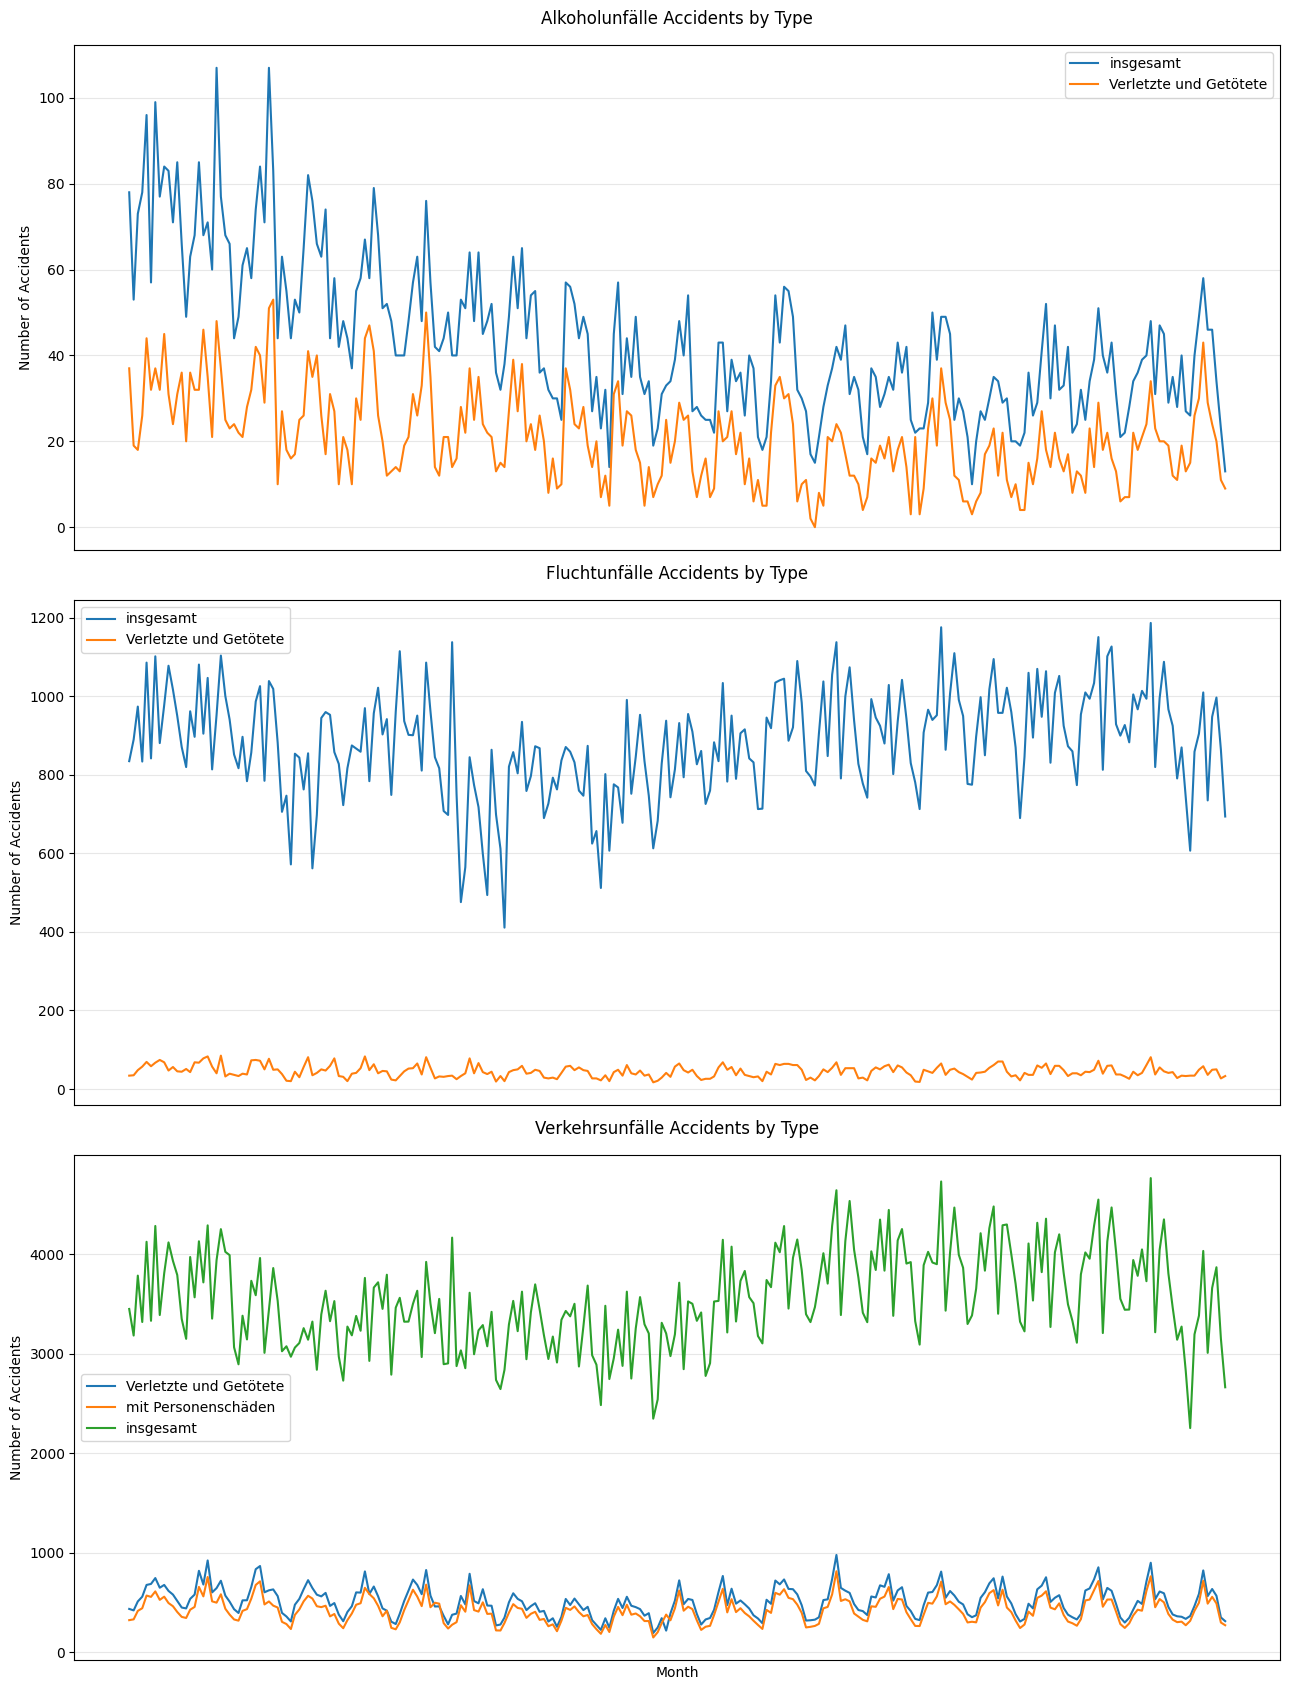

In [5]:
fig = create_visualizations(df)
plt.savefig('traffic_accidents_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
print_detailed_statistics(df)

       Category          Accident Type  Monthly average  Maximum  Minimum  Standard deviation  Total change 2000-2020 (%) Peak Month  Peak Month Avg Lowest Month  Lowest Month Avg
 Alkoholunfälle              insgesamt             43.8    107.0     10.0                18.1                       -54.0         09            57.7           02              32.0
 Alkoholunfälle Verletzte und Getötete             20.7     53.0      0.0                10.7                       -33.5         07            31.3           02              12.1
  Fluchtunfälle              insgesamt            879.4   1187.0    411.0               135.2                       -12.6         07          1001.9           01             761.0
  Fluchtunfälle Verletzte und Getötete             44.9     85.0     17.0                15.0                       -29.3         07            65.1           01              28.4
Verkehrsunfälle Verletzte und Getötete            511.5    976.0    192.0               148.7       

The statistics and the figure shows the data have strong sesonal rule.

## Model 1: SARIMAX



In [7]:
df_alcohol = df[(df['Category'] == 'Alkoholunfälle') & 
                (df['AccidentType'] == 'insgesamt')]

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime

# 设置 Date 列为索引
df_sarimax = df_alcohol.set_index('Date')

# 选择 Value 列作为目标变量
y = df_sarimax['Value']

# 划分数据为训练集和验证集
train = y[:'2019-12-01']  # 2019年及之前的数据
validation = y['2020-01-01':'2020-12-01']  # 2020年的数据

# 在验证集上训练和评估模型
model_validation = SARIMAX(train,
                          order=(1, 1, 1),
                          seasonal_order=(1, 1, 1, 12),
                          enforce_stationarity=False,
                          enforce_invertibility=False)
results_validation = model_validation.fit()

# 对验证集进行预测
validation_predictions = results_validation.predict(start='2020-01-01', 
                                                  end='2020-12-01', 
                                                  dynamic=False)

# 计算验证集的误差指标
mae = np.mean(np.abs(validation - validation_predictions))
rmse = np.sqrt(np.mean((validation - validation_predictions)**2))

print("验证集性能评估：")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# 使用全部数据训练最终模型（到2020年底）
final_train = y[:'2020-12-01']
final_model = SARIMAX(final_train,
                      order=(1, 1, 1),
                      seasonal_order=(1, 1, 1, 12),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
final_results = final_model.fit()

# 预测2021年1月的数据
forecast = final_results.predict(start='2021-01-01', 
                               end='2021-01-01', 
                               dynamic=False)

# 输出最终预测结果和实际值的比较
print(f"Predicted Value for 2021-01: {forecast[0]:.2f}")



/Users/Gewai/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/Gewai/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22957D+00    |proj g|=  1.30021D-01

At iterate    5    f=  3.18978D+00    |proj g|=  1.22246D-01

At iterate   10    f=  3.11965D+00    |proj g|=  2.91885D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   3.409D-06   3.120D+00
  F =   3.1196462996463348     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (

/Users/Gewai/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/Gewai/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.14416D+00    |proj g|=  3.13299D-02

At iterate   15    f=  3.14348D+00    |proj g|=  7.66077D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   2.121D-06   3.143D+00
  F =   3.1434767257901810     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Predicted Value for 2021-01: 21.40


## Model 2: XGBoost

In [9]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_features(df):
    """Create features for the model"""
    df = df.copy()
    
    # Time-based features
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    
    # Seasonal features
    df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
    df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)
    
    # Sort by date before creating lag features
    df = df.sort_values('Date')
    
    # Lag features
    df['last_month'] = df['Value'].shift(1)
    df['last_year'] = df['Value'].shift(12)
    
    # Moving averages
    df['rolling_mean_3'] = df['Value'].rolling(window=3).mean()
    df['rolling_mean_6'] = df['Value'].rolling(window=6).mean()
    df['rolling_mean_12'] = df['Value'].rolling(window=12).mean()
    
    return df

# Create features
df_features = create_features(df_alcohol)
df_features = df_features.dropna()

print("Features created. Data shape:", df_features.shape)
print("\nFeature columns:")
new_features = [
    'year', 'month', 'is_summer', 'is_winter', 
    'last_month', 'last_year', 'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12'
]
print(new_features)


Features created. Data shape: (240, 15)

Feature columns:
['year', 'month', 'is_summer', 'is_winter', 'last_month', 'last_year', 'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12']


In [ ]:
# Prepare modeling data
features = [
    'year', 'month', 'is_summer', 'is_winter',
    'last_month', 'last_year', 'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12'
]

X = df_features[features]
y = df_features['Value']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

model.fit(X_train, y_train)

# Evaluate model
val_pred = model.predict(X_val)
mse = mean_squared_error(y_val, val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, val_pred)

print("Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")


In [ ]:
# Predict January 2021
last_data = df_features.iloc[-1]

pred_data = pd.DataFrame({
    'year': [2021],
    'month': [1],
    'is_summer': [0],
    'is_winter': [1],
    'last_month': [last_data['Value']],
    'last_year': [df_features[df_features['month'] == 1]['Value'].iloc[-1]],
    'rolling_mean_3': [df_features['Value'].tail(3).mean()],
    'rolling_mean_6': [df_features['Value'].tail(6).mean()],
    'rolling_mean_12': [df_features['Value'].tail(12).mean()]
})

prediction = model.predict(pred_data)[0]
print(f"Predicted accidents for 202101: {prediction:.0f}")

Predicted accidents for 202101: 17


## LightGBM

In [ ]:
import lightgbm as lgb

# Train model with LightGBM
model_gbm = lgb.LGBMRegressor(
   n_estimators=100,
   learning_rate=0.1,
   max_depth=5,
   num_leaves=31, 
   random_state=42
)

model_gbm.fit(X_train, y_train)

# Evaluate LightGBM model
val_pred_gbm = model_gbm.predict(X_val)
mse_gbm = mean_squared_error(y_val, val_pred_gbm)
rmse_gbm = np.sqrt(mse_gbm)
r2_gbm = r2_score(y_val, val_pred_gbm)

print("\nLightGBM Model Performance:")
print(f"RMSE: {rmse_gbm:.2f}")
print(f"R2 Score: {r2_gbm:.2f}")

# Predict January 2021 using LightGBM
prediction_gbm = model_gbm.predict(pred_data)[0]
print(f"LightGBM Predicted accidents for 202101: {prediction_gbm:.0f}")

# Compare predictions from both models
print("\nModel Comparison for January 2021:")
print(f"XGBoost prediction: {prediction:.0f}")
print(f"LightGBM prediction: {prediction_gbm:.0f}")
print(f"Difference: {abs(prediction - prediction_gbm):.0f}")


In [ ]:
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
})
importance = importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance['feature'], importance['importance'])
plt.xticks(rotation=45)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# API Endpoint

In [ ]:
from flask import Flask, request, jsonify
import joblib
import numpy as np
import logging

# 创建 Flask 应用
app = Flask(__name__)

# 配置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 加载模型
try:
    model = joblib.load('model.joblib')
    logger.info("Load model")
except Exception as e:
    logger.error(f"Fail to load model: {str(e)}")
    model = None

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # 获取请求数据
        data = request.get_json()
        
        # 验证输入数据
        if not data or 'year' not in data or 'month' not in data:
            return jsonify({'error': 'Must have year and month'}), 400
            
        year = data['year']
        month = data['month']
        
        # 输入验证
        if not isinstance(year, int) or not isinstance(month, int):
            return jsonify({'error': 'Please enter int'}), 400
            
        if month < 1 or month > 12:
            return jsonify({'error': '1 <= month <= 12'}), 400
        
        # 特征预处理
        features = np.array([[year, month]])
        
        # 预测
        prediction = model.predict(features)[0]
        
        # 返回预测结果
        return jsonify({
            'prediction': float(prediction)  # 转换为 float 以确保 JSON 序列化
        })
        
    except Exception as e:
        logger.error(f"预测过程发生错误: {str(e)}")
        return jsonify({'error': '预测服务发生错误'}), 500

# 健康检查端点
@app.route('/health', methods=['GET'])
def health():
    if model is not None:
        return jsonify({'status': 'healthy', 'model_loaded': True})
    return jsonify({'status': 'unhealthy', 'model_loaded': False}), 503

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=8000)